# Project - Analyzing Chess Results with Python

## Data Preparation

I aim to analyze a database of classical chess games in python in order to assess how well ELO ratings can predict wins and losses, and to see if there are any more accurate ways to do so by including more variables.

In [1]:
import pandas as pd
import numpy as np 
import re
import math
import io
import annotator
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import chess
import chess.pgn
import time
import chess.engine
import warnings
warnings.filterwarnings('ignore')

import seaborn as sb

In [ ]:
# Load Scalene
%load_ext scalene

In [2]:
def get_eval(game,n = None, t = None):
    # Note - I would like to make a class which contains all important metrics for my neural net
    board = game.board()
    move_number = 0
    white = []
    black = []
    centipawns = []
    engine = chess.engine.SimpleEngine.popen_uci("stockfish_15_win_x64_avx2\\stockfish_15_x64_avx2.exe")
    engine.configure({"Threads": 8}) # or even higher

    for move in game.mainline_moves():
        #print(move)
        board.push(move)
        if move_number == 20:
            info = engine.analyse(board, chess.engine.Limit(depth = n,time=t))
            prev_centipawn = info["score"].white().score()
        if move_number > 20:
            info = engine.analyse(board, chess.engine.Limit(depth = n,time = t))
            centipawn = info["score"].white().score()
            if centipawn is None:
                centipawn = 0
            if move_number % 2 == 0:
                white.append(centipawn - prev_centipawn)
            else:
                black.append(- (centipawn - prev_centipawn))
            prev_centipawn = centipawn
            centipawns.append(centipawn)
        move_number +=1
    engine.quit()
    return white, black, centipawns

ERROR! Session/line number was not unique in database. History logging moved to new session 645


In [3]:
class Eval:
    def __init__(self, moves, n):
        self.moves = moves
        self.game = chess.pgn.read_game( io.StringIO(self.moves))
        self.white_eval,self.black_eval,self.centipawns  = get_eval(self.game, n)

In [4]:
players = ['andreikin, dmitry', 'anand, viswanathan', 'wang, hao', 'grischuk, alexander', 'karjakin, sergey','duda, jan-krzysztof', 'radjabov, teimour', 'dominguez perez, leinier','nakamura, hikaru', 'vachier-lagrave, maxime','aronian, levon','mamedyarov, shakhriyar', 'so, wesley','ding, liren', 'rapport, richard', 'nepomniachtchi, ian', 'giri, anish', 'firouzja, alireza', 'caruana, fabiano']

#merging the 20 individual csvs
dfs = []
i = 0
for player in players:
    df = pd.read_csv('csvs/' +player +'.csv', index_col=None, header=0)
    df.to_csv(str(i)+ '.csv')
    dfs.append(df)
#db = pd.concat(dfs, axis=0, ignore_index=True)


KeyboardInterrupt



In [ ]:
def to_eval(x,n):
    eval = Eval(x,n)
    return eval

In [ ]:
# testing the time to run through 268 games: not going to be quick but only need to do it once
def evaluate(dx):
    db = dx.copy()
    start = time.time()
    db['Game'] = db['Game'].apply(lambda x : to_eval(x,2).centipawns)
    end = time.time()
    print(f"time elapsed:", end-start)
    return db

In [ ]:
%%scalene --reduced-profile

In [ ]:
print(dfs[0])

In [24]:
i = 0
for df in dfs:
    df['Centipawns'] = df['Game']
    df.to_csv(str(i) +'.csv')
    i +=1
# note I haven't added the game column to the rest of the csvs, just the first. This is why I get the error. It's fine for testing to just use the first csv though

KeyError: 'Game'

In [26]:
for i in range(len(dfs)):
    try:
        df= pd.read_csv('annotated' +str(i) +'.csv')
    except:
        df= pd.read_csv(str(i) +'.csv')
    for index,row in df.iterrows():
        if row['Game'] == row['Centipawns']:
            start = time.time()
            df.at[index,'Game'] = to_eval(row['Game'] ,20).centipawns
            df.to_csv('annotated' + str(i) +'.csv')
            print(index)
            end = time.time()
            print(f"time elapsed:", end-start)
    i +=1

0
time elapsed: 56.77805137634277



KeyboardInterrupt



In [ ]:
# note I need to edit this so that it uses the same csvs each time

In [13]:
%load_ext line_profiler

In [38]:
game = db['Game'][3]
game_obj = to_eval(game, 8)

In [40]:
%lprun -f get_eval get_eval(game_obj.game, 8)

In [35]:
%lprun -f to_eval get_eval(game, 10)

AttributeError: 'str' object has no attribute 'board'

In [26]:
%lprun -f evaluate evaluate(db)

*** KeyboardInterrupt exception caught in code being profiled.

In [15]:
import scalene

In [22]:
%%scalene --reduced-profile
x = 0
for i in range(1000):
    for j in range(1000):
        x += 1

In [17]:
def test_run():
    x = 0
    for i in range(1000):
        for j in range(1000):
            x += 1

In [19]:
%scrun test_run()

In [13]:
print(db.value_counts('Event'))

Event
*                     171
swiss                  21
blitz                  19
tourn                  16
rapid                  11
swiss (blitz)           8
k.o.                    6
swiss (rapid)           5
team-swiss              4
k.o. (blitz)            4
team-tourn              4
team                    2
match (blitz)           2
team-swiss (blitz)      1
team-swiss (rapid)      1
team (blitz)            1
team-tourn (blitz)      1
tourn (blitz)           1
tourn (rapid)           1
dtype: int64


I will remove all blitz, rapid and correspondence games, and also remove any games with null values in any of the columns. I am also removing team games as I'm not interested in these either.

In [127]:
#Removing any rows with null values
db = db.replace('*', np.nan)
db = db.replace('?', np.nan)
db = db.dropna()

In [128]:
#Converting rounds to numeric and rounding down
db['Rounds'] = pd.to_numeric(db['Rounds']).apply(math.floor)

In [129]:
db = db[db["Event"].str.contains(r"blitz|rapid|k.o.|team|simul|corr")==False ]
print(db.value_counts('Event'))

Event
tourn    6630
swiss    4234
match     430
schev     296
game       62
dtype: int64


In [130]:
#Adding a column for ELO-implied expected points and ELO difference (White - Black)
db['Diff'] = db['WhiteELO'] - db['BlackELO']
db['Diff'] = pd.to_numeric(db['Diff'],errors='raise')
db['ExpWhitePoints'] = 1/(1+(10**((-db['Diff'])/400)))
db['ExpWhitePoints'] = pd.to_numeric(db['ExpWhitePoints'],errors='raise')

In [131]:
#Replacing the strings in the result column with numeric values for white's points.
db['WhitePoints'] = db['Result'].replace(r'0-\d', '0', regex=True)
db['WhitePoints'] = db['WhitePoints'].replace(r'1-\d', '1', regex=True)
db['WhitePoints'] = db['WhitePoints'].replace(r'1/2-\d.\d', '0.5', regex=True)
db['WhitePoints'] = pd.to_numeric(db['WhitePoints'],errors='raise')

## Exploratory Data Analysis

I would expect difference in ELO to be a strong indicator of whether white will win, draw or lose.

[Text(0.5, 1.0, 'Difference in ELO vs Whites points'),
 Text(0.5, 0, 'Whites points'),
 Text(0, 0.5, 'White ELO - Black ELO')]

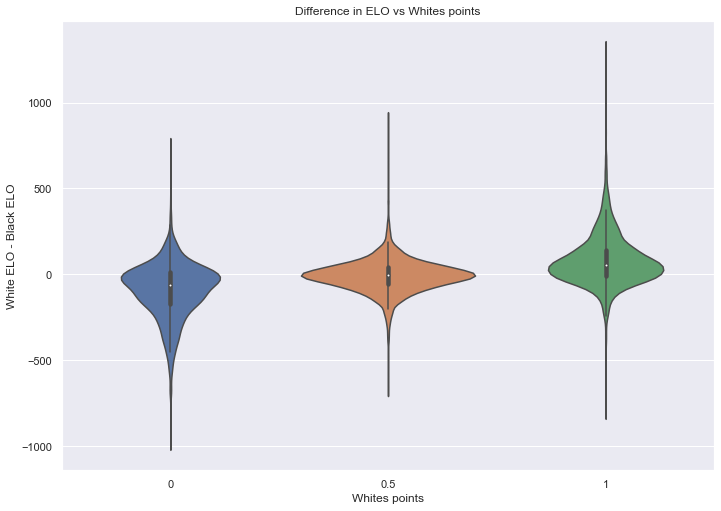

In [132]:
sb.set(rc={'figure.figsize':(11.7,8.27)})
sb.violinplot(x = 'WhitePoints', y = "Diff", order=[0, 0.5,1],data = db).set(title = 'Difference in ELO vs White''s points',xlabel = 'White''s points', ylabel = 'White ELO - Black ELO')

Text(0, 0.5, 'Average Points')

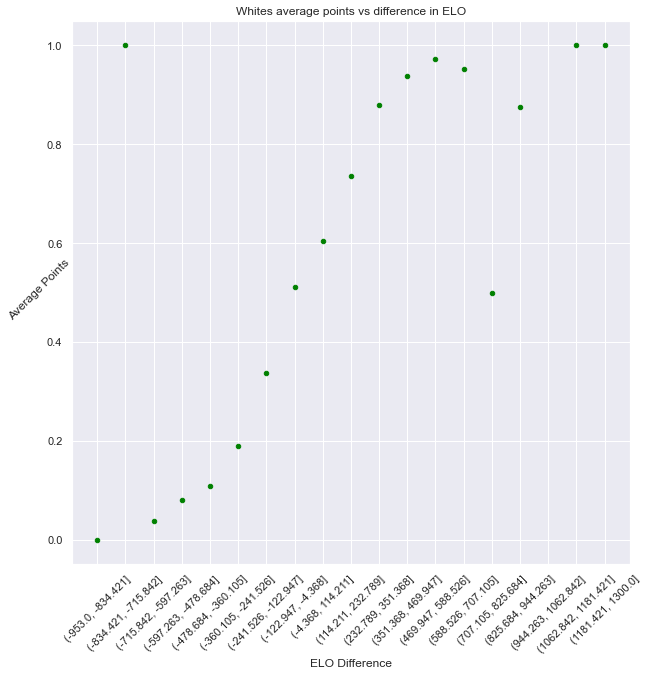

In [133]:
#Sorting the data into 20 bins by ELO Difference
lb =db['Diff'].min().astype(int)
ub = db['Diff'].max().astype(int)
db_cut = db[['Diff','WhitePoints']]
db_cut = db_cut.sort_values(by = 'Diff',ascending=True)
bins =np.linspace(lb,ub,20)
db_cut['bins'] = pd.cut(db_cut['Diff'], bins = bins)

db_cut = db_cut[['bins','WhitePoints']]
db_cut_grouped = db_cut.groupby('bins').mean()
db_cut_grouped['bins'] = db_cut_grouped.index.astype(str)
ax = db_cut_grouped.plot.scatter(x='bins', y = 'WhitePoints', color = 'green', figsize = (10,10), rot = 45, title = 'White''s average points vs difference in ELO')
ax.set_xlabel('ELO Difference')
ax.set_ylabel('Average Points', rotation = 45)

Text(0, 0.5, 'Average Points')

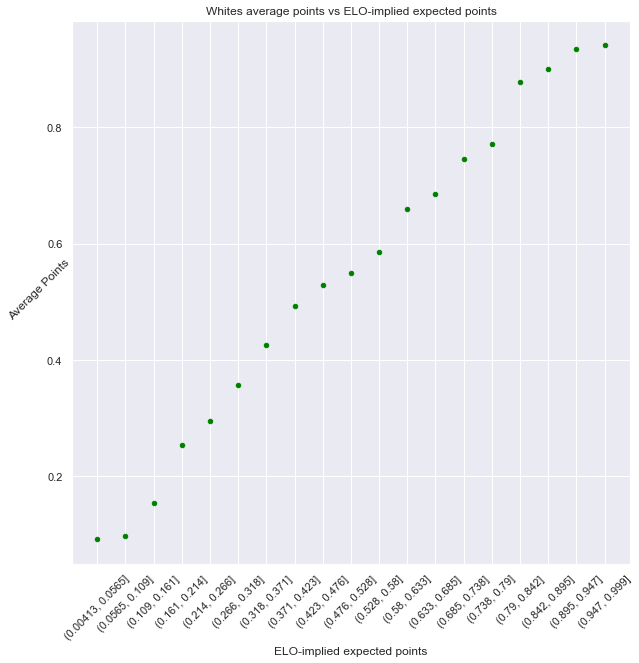

In [134]:
#Sorting the data into 20 bins by ELO-implied expected points
lb =db['ExpWhitePoints'].min().astype(float)
ub = db['ExpWhitePoints'].max().astype(float)
db_cut_ex = db[['ExpWhitePoints','WhitePoints']]
db_cut_ex = db_cut_ex.sort_values(by = 'ExpWhitePoints',ascending=True)
bins =np.linspace(lb,ub,20)
db_cut_ex['bins'] = pd.cut(db_cut_ex['ExpWhitePoints'], bins = bins)#[-1500,-1400,-1300,-1200,-1100,-1000,-900,-800,-700,-600,-500,0,1500])
db_cut = db_cut_ex[['bins','WhitePoints']]
db_cut_ex_grouped = db_cut_ex.groupby('bins').mean()
db_cut_ex_grouped['bins'] = db_cut_ex_grouped.index.astype(str)
ax =db_cut_ex_grouped.plot.scatter(x='bins', y = 'WhitePoints', color = 'green', figsize = (10,10), rot = 45, title = 'White''s average points vs ELO-implied expected points')
ax.set_xlabel('ELO-implied expected points')
ax.set_ylabel('Average Points', rotation = 45)

This looks like a more clear linear relationship. Since I want to get the probability of a draw and a win, expected points alone doesn't provide enough information, but the mean squared error of the ELO-implied expected points might be an interesting benchmark to test a model's predicted points against.

In [135]:
print(mean_squared_error(db['WhitePoints'],db['ExpWhitePoints']))
print(mean_absolute_error(db['WhitePoints'],db['ExpWhitePoints']))

0.09884869571688575
0.24124305801026902


# Multinomial Logistic Regression

Running a multinomial regression, adding a variable 

In [136]:
#Setting a win to 2 and a draw to 1
db['WhitePoints'] = db['WhitePoints'].replace(1, 2, regex=True)
db['WhitePoints'] = db['WhitePoints'].replace(0.5, 1, regex=True)
db['ExpWhitePoints2'] = db['ExpWhitePoints']**2
db['Diff2'] = db['Diff']**2
db['WhiteELO2'] = db['WhiteELO']**2

In [137]:
X = db[['ExpWhitePoints','Diff','ExpWhitePoints2','WhiteELO', 'Diff2', 'WhiteELO2']]
Y_labels = db[['WhitePoints']]
X_train, X_test, y_train, y_test = train_test_split(X, Y_labels, test_size=0.25, random_state =41, shuffle = True)

In [138]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [139]:
predicted = model.predict(X_train)
print("Accuracy for Train ", round(accuracy_score(y_train,predicted),3))

Accuracy for Train  0.604


In [140]:
predicted1 = model.predict(X_test)
print("Accuracy for Test: ", round(accuracy_score(y_test,predicted1),3))

Accuracy for Test:  0.586


In [141]:
print(log_loss(y_test, model.predict_proba(X_test)))

0.918863669719975


In [142]:
#Adding event type as a categorical variable
db= pd.get_dummies(db, columns = ['Event'])

# Cross-Validation and Hyper-Parameter Tuning

In [143]:
#Frst running without the squared variables
X = db[['ExpWhitePoints','Diff','WhiteELO','Event_game', 'Rounds','Event_match', 'Event_schev', 'Event_swiss', 'Event_tourn']]
Y_labels = db[['WhitePoints']]

X_train, X_test, y_train, y_test = train_test_split(X, Y_labels, test_size=0.2, random_state =66)


#my parameter grid
parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear']
    }

logreg = LogisticRegression(random_state=41)

clf = GridSearchCV(logreg,                    
                   param_grid = parameters,   
                   scoring='neg_log_loss',        
                   cv=10)
clf.fit(X_train,y_train)

print("Tuned Hyperparameters :", clf.best_params_)
print("Score :",clf.best_score_)



Tuned Hyperparameters : {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
Score : -0.8946487650849203


In [144]:
logreg = LogisticRegression(C = .01, 
                            penalty = 'l2', 
                            solver = 'newton-cg')
logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test)
print("Accuracy:",logreg.score(X_test, y_test))

pred = logreg.predict_proba(X_test)
print(log_loss(y_test, pred))

#Examining coefficients
logreg.coef_[0]
df_0 = pd.DataFrame(logreg.coef_[0], 
             X_train.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)
df_1 = pd.DataFrame(logreg.coef_[1], 
             X_train.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

df_2 = pd.DataFrame(logreg.coef_[2], 
             X_train.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

print('Loss:\n',df_0)
print('\nDraw:\n',df_1)
print('\nWin:\n',df_2)

Accuracy: 0.6190476190476191
0.8914841270189818
Loss:
                     coef
Event_schev     0.054940
Event_match     0.031976
Event_swiss     0.016419
ExpWhitePoints  0.003903
WhiteELO       -0.000852
Rounds         -0.004455
Diff           -0.004628
Event_game     -0.007332
Event_tourn    -0.095973

Draw:
                     coef
Event_tourn     0.092302
Event_match     0.030830
Event_game      0.013226
Rounds          0.004700
WhiteELO        0.001379
Diff           -0.001233
ExpWhitePoints -0.022474
Event_swiss    -0.027056
Event_schev    -0.109347

Win:
                     coef
Event_schev     0.054407
ExpWhitePoints  0.018571
Event_swiss     0.010636
Diff            0.005861
Event_tourn     0.003671
Rounds         -0.000245
WhiteELO       -0.000527
Event_game     -0.005894
Event_match    -0.062805


In [145]:
#Adding in the squares of Diff, WhiteELO and ELO-implied expected points.
X = db[['ExpWhitePoints','Diff','ExpWhitePoints2','WhiteELO','Event_game', 'Rounds','Event_match', 'Event_schev', 'Event_swiss', 'Event_tourn', 'Diff2', 'WhiteELO2']]
Y_labels = db[['WhitePoints']]

X_train, X_test, y_train, y_test = train_test_split(X, Y_labels, test_size=0.2, random_state =66)


#my parameter grid
parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear']
    }

logreg = LogisticRegression(random_state=41)

clf = GridSearchCV(logreg,                    
                   param_grid = parameters,   
                   scoring='neg_log_loss',        
                   cv=10)
clf.fit(X_train,y_train)

print("Tuned Hyperparameters :", clf.best_params_)
print("Score :",clf.best_score_)

Tuned Hyperparameters : {'C': 100.0, 'penalty': 'l1', 'solver': 'liblinear'}
Score : -0.8912612988052852


In [146]:
logreg = LogisticRegression(C = 100, 
                            penalty = 'l1', 
                            solver = 'liblinear')
logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test)
print("Accuracy:",logreg.score(X_test, y_test))

pred = logreg.predict_proba(X_test)
print(log_loss(y_test, pred))

Accuracy: 0.61003861003861
0.8872744808509068


In [147]:
#Examining coefficients
logreg.coef_[0]
df_0 = pd.DataFrame(logreg.coef_[0], 
             X_train.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)
df_1 = pd.DataFrame(logreg.coef_[1], 
             X_train.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

df_2 = pd.DataFrame(logreg.coef_[2], 
             X_train.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

print('Loss:\n',df_0)
print('\nDraw:\n',df_1)
print('\nWin:\n',df_2)

Loss:
                          coef
ExpWhitePoints2  2.377952e+00
Event_schev      9.844150e-01
Event_match      7.995445e-01
Event_swiss      7.147568e-01
Event_game       5.607751e-01
Event_tourn      5.300610e-01
WhiteELO2       -1.871748e-07
Diff2           -1.057722e-06
WhiteELO        -1.788212e-04
Rounds          -1.696872e-03
Diff            -7.704832e-03
ExpWhitePoints  -7.939489e-01

Draw:
                          coef
ExpWhitePoints   1.451988e-01
Diff             4.706415e-03
Rounds           2.142220e-03
WhiteELO         3.226711e-04
WhiteELO2        2.729096e-07
Diff2           -7.205095e-06
Event_game      -4.474578e-01
Event_tourn     -4.641684e-01
Event_match     -5.038458e-01
Event_swiss     -5.932012e-01
Event_schev     -9.600759e-01
ExpWhitePoints2 -6.116725e+00

Win:
                          coef
ExpWhitePoints2  8.354847e-01
ExpWhitePoints   4.774817e-01
Event_schev      9.252343e-02
Diff             5.821348e-03
Rounds           3.312555e-04
Diff2            3

# Calculating expected points mean squared error

In [148]:
def exp_points(predictions):
    exps = []
    for prediction in predictions:
        exp = 0.5*prediction[1] + prediction[2]
        exps.append(exp)
    return exps
    
pred = logreg.predict_proba(X_test)
white_true_points = y_test/2

#Calculating MSE and MAE for the model's implied expected points
print(mean_squared_error(white_true_points,exp_points(pred)))
print(mean_absolute_error(white_true_points,exp_points(pred)))

0.09599986093740645
0.2352282409391833


Mean squared error and mean absolute error for our predicted points are lower than than for the implied ELO predicted points! So as well as also having a predictor of wins & draws, we seem to have a better predictor of points.

In [149]:
#Calculating MSE and MAE for the ELO-implied expected points
print(mean_squared_error(y_test/2,X_test['ExpWhitePoints']))
print(mean_absolute_error(y_test/2,X_test['ExpWhitePoints']))

0.09901997775822821
0.23965898354272908


Text(0, 0.5, 'Average Points')

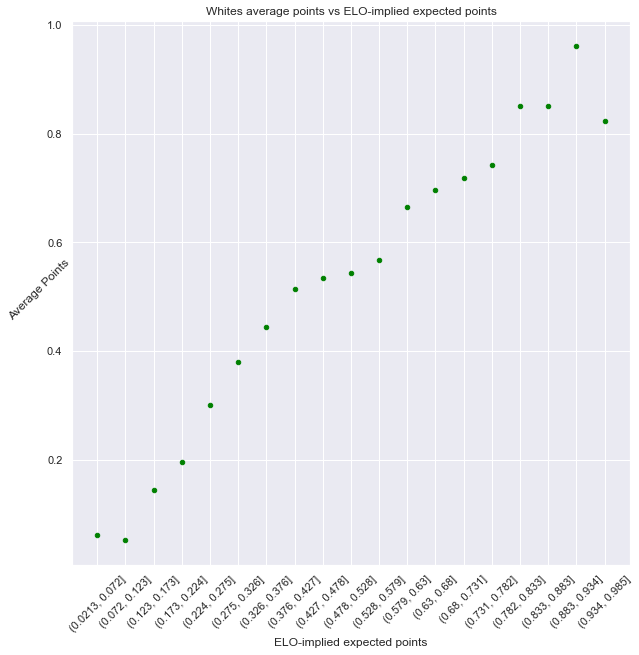

In [150]:
#Plotting ELO-implied expected points vs actual poins for the test data 
lb =X_test['ExpWhitePoints'].min().astype(float)
ub = X_test['ExpWhitePoints'].max().astype(float)
X_test['WhitePoints'] = y_test/2
X_test_cut_ex = X_test[['ExpWhitePoints','WhitePoints']]
X_test_cut_ex = X_test_cut_ex.sort_values(by = 'ExpWhitePoints',ascending=True)
bins =np.linspace(lb,ub,20)
X_test_cut_ex['bins'] = pd.cut(X_test_cut_ex['ExpWhitePoints'], bins = bins)
X_test_cut = X_test_cut_ex[['bins','WhitePoints']]
X_test_cut_ex_grouped = X_test_cut_ex.groupby('bins').mean()
X_test_cut_ex_grouped['bins'] = X_test_cut_ex_grouped.index.astype(str)
ax =X_test_cut_ex_grouped.plot.scatter(x='bins', y = 'WhitePoints', color = 'green', figsize = (10,10), rot = 45, title = 'White''s average points vs ELO-implied expected points')
ax.set_xlabel('ELO-implied expected points')
ax.set_ylabel('Average Points', rotation = 45)

Text(0, 0.5, 'Average Points')

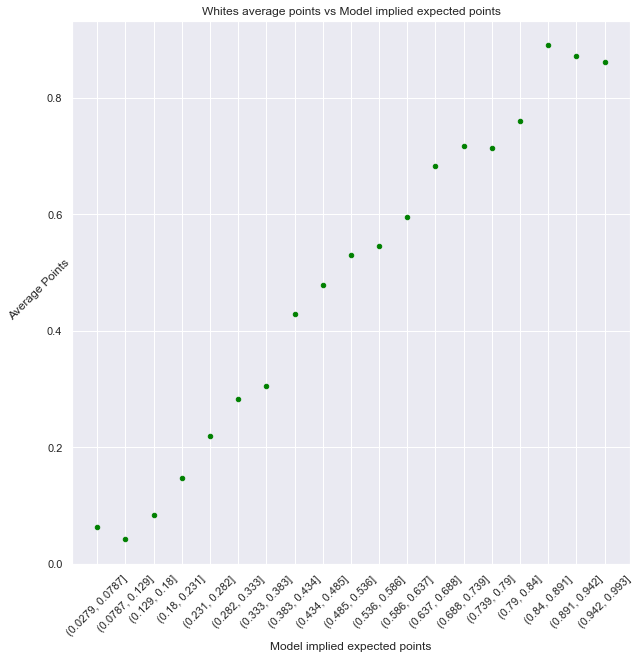

In [151]:
#Plotting the model's implied expected points vs actual poins for the test data 

#changing expected points to my model's expected points
X_test['ExpWhitePoints'] = exp_points(pred)

lb =X_test['ExpWhitePoints'].min().astype(float)
ub = X_test['ExpWhitePoints'].max().astype(float)
X_test['WhitePoints'] = y_test/2
X_test_cut_ex = X_test[['ExpWhitePoints','WhitePoints']]
X_test_cut_ex = X_test_cut_ex.sort_values(by = 'ExpWhitePoints',ascending=True)
bins =np.linspace(lb,ub,20)
X_test_cut_ex['bins'] = pd.cut(X_test_cut_ex['ExpWhitePoints'], bins = bins)
X_test_cut = X_test_cut_ex[['bins','WhitePoints']]
X_test_cut_ex_grouped = X_test_cut_ex.groupby('bins').mean()
X_test_cut_ex_grouped['bins'] = X_test_cut_ex_grouped.index.astype(str)
ax =X_test_cut_ex_grouped.plot.scatter(x='bins', y = 'WhitePoints', color = 'green', figsize = (10,10), rot = 45, title = 'White''s average points vs Model implied expected points')
ax.set_xlabel('Model implied expected points')
ax.set_ylabel('Average Points', rotation = 45)